# Imports

In [1]:
# current filepath system leaves plenty to be desired
import sys
local_path = '/Users/hinzlehome/codeup-data-science/binance-project/'
sys.path.insert(0, local_path)

# imports.py in /utils/
from utils.imports import *

# plotting magic
%matplotlib inline
# plotting defaults
plt.rc('figure', figsize=(16, 9))
plt.style.use('seaborn-darkgrid')
plt.rc('font', size=16)
# plt.style.available
# ^^^ show available seaborn styles

# !!! Warning !!! 
# *** no more warnings ***
# import warnings
# warnings.filterwarnings("ignore")

# custom mods
from utils.tidy import *
from utils.model import *


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
train,validate,test=btcusd()

cached csv


In [3]:
train.head()

,open_time,open,high,low,close,volume,quote_asset,number_of_trades,taker_buy_base_asset_vol,taker_buy_quote_asset_vol
close_time,,,,,,,,,,
2022-04-25 03:34:59.999,1650857640000,39241.39,39247.11,39241.03,39241.03,0.034305,1346.2987,5,0.032395,1271.3484
2022-04-25 03:35:59.999,1650857700000,39239.88,39272.32,39239.88,39246.41,2.441750,95844.1921,65,1.473456,57836.1693
2022-04-25 03:36:59.999,1650857760000,39245.53,39249.18,39230.06,39232.18,0.103794,4072.9587,24,0.052915,2076.4194
2022-04-25 03:37:59.999,1650857820000,39233.21,39238.46,39232.93,39232.93,0.019871,779.6247,8,0.007287,285.9047
2022-04-25 03:38:59.999,1650857880000,39232.49,39248.38,39232.20,39238.10,0.056483,2216.3283,13,0.048939,1920.2979


# Making Modeling

In [30]:
def split_plot(train,validate,test,col='close'):
    plt.figure(figsize=(16,9))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col+' price')
    plt.xlabel(col+' time')
    plt.title('btcusd 1m kline, close price')
    plt.show()

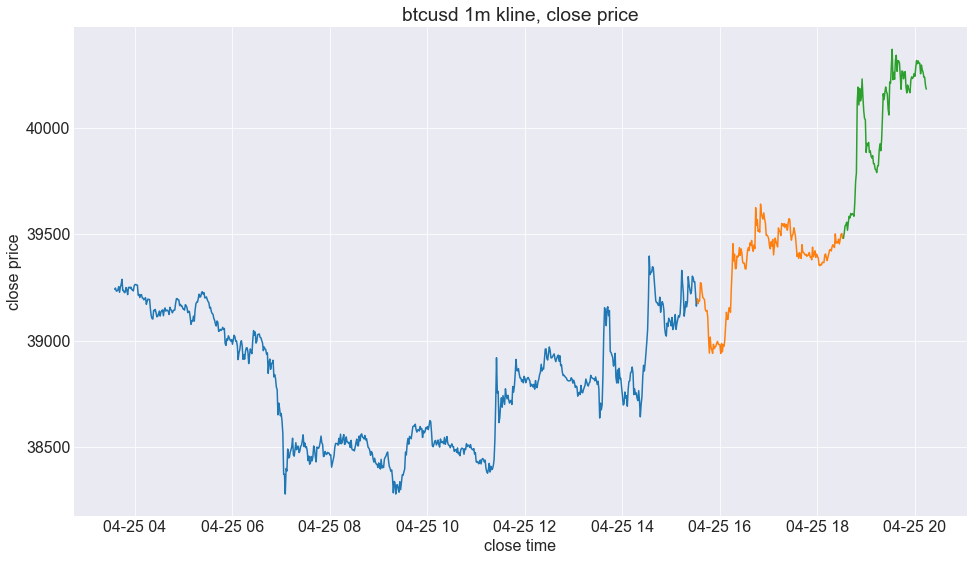

In [31]:
split_plot(train,validate,test)

# yhat func

In [36]:
def yhat_model(train):
	# last observed value
	lov = train['close'][-1:][0]
	# add lov to yhat
	yhat_df = pd.DataFrame({'close': validate.close,'lov': [lov]},index = validate.index)
	# calc avg
	avg =round(train.close.mean(),3)
	avg = pd.DataFrame({'avg': [avg]},index = validate.index)
	# add avg to yhat
	yhat_df=pd.concat([yhat_df,avg],axis=1)
	# calc simple moving average using TAlib
	sma=talib.SMA(train.close,10)
	sma=round(sma[-1],3)
	sma = pd.DataFrame({'sma': [sma]},index = validate.index)
	# add sma to yhat
	yhat_df=pd.concat([yhat_df,sma],axis=1)
	# calc holt's linear trend prediction
	model = Holt(train.close, exponential = True)
	model = model.fit(smoothing_level = .1, 
						smoothing_slope = .1, 
						optimized = False)
	# add holts to yhat
	yhat_items = model.predict(start = validate.index[0], 
								end = validate.index[-1])
	yhat_df['holt'] = round(yhat_items, 2)

	#plot yhat
	#sns.set_palette("PuRd")
	g = sns.JointGrid()
	g.fig.set_figwidth(16)
	g.fig.set_figheight(9)
	sns.lineplot(data=yhat_df,ax=g.ax_joint)
	sns.lineplot(data=train.close,ax=g.ax_joint)
	#sns.kdeplot(yhat_df.close, linewidth=2, ax=g.ax_joint)
	return yhat_df



/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/var/folders/mk/w2hz4wxx7xn5hr_56wz536gh0000gn/T/ipykernel_10604/2043871890.py:19: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model = model.fit(smoothing_level = .1,


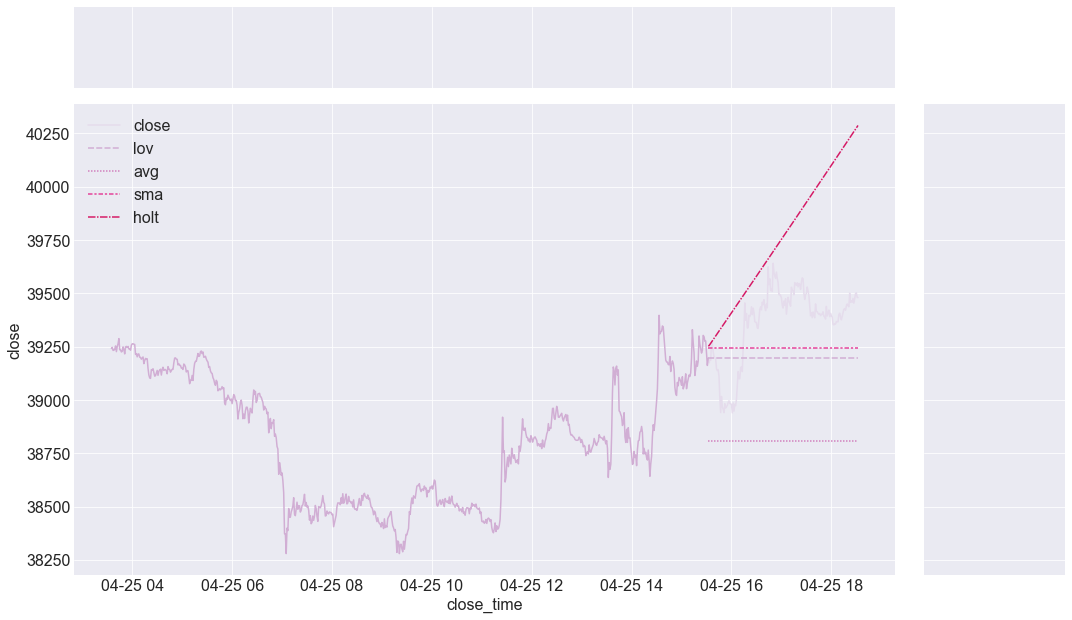

In [37]:
yhat_df=yhat_model(train)

In [23]:
yhat_df.head()

,close,lov,avg,sma,holt
close_time,,,,,
2022-04-25 15:31:59.999,39195.35,39195.35,38806.14,39242.007,39254.29
2022-04-25 15:32:59.999,39173.15,39195.35,38806.14,39242.007,39254.09
2022-04-25 15:33:59.999,39190.45,39195.35,38806.14,39242.007,39259.79
2022-04-25 15:34:59.999,39185.52,39195.35,38806.14,39242.007,39265.49
2022-04-25 15:35:59.999,39271.97,39195.35,38806.14,39242.007,39271.18


# RMSE func

In [50]:
def rmse_model(yhat_df):
	# start eval_df for rmse storage
	eval_df=pd.DataFrame()
	# comb through yhat and calc rmse, not close
	for col in yhat_df.columns:
		if col == 'close':
			print('skipping close')
			continue
		else:
			print(col)
			# calc rmse 
			x=mean_squared_error(yhat_df.close,yhat_df[col],squared=False)
			# add to eval_df
			eval_df=pd.concat([eval_df,pd.DataFrame({col:[x]})],axis=1)
	# plot eval_df
	#sns.set_palette("PuRd")
	p=sns.barplot(data=eval_df)
	p.set_xlabel('Model')
	p.set_ylabel('RMSE')
	return eval_df

skipping close
lov
avg
sma
holt


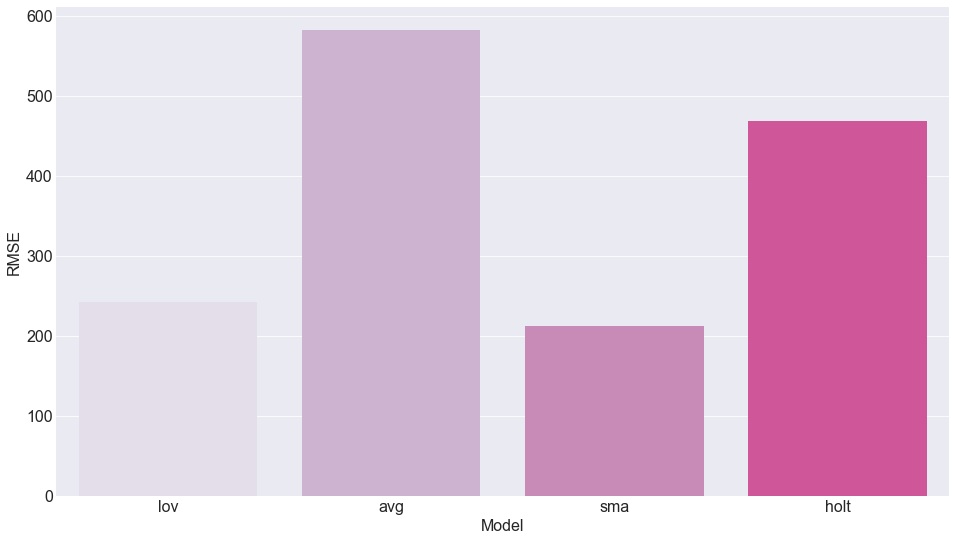

In [51]:
eval_df=rmse_model(yhat_df)

In [21]:
eval_df.head()

,lov,avg,sma,holt
0,242.149605,581.652564,213.179082,468.632256


# SMA for the WIN!!
